Importing useful libraries

In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from torchvision.datasets import VOCSegmentation
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from skimage.segmentation import mark_boundaries
from torchsummary import summary
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

**[Importing data from drive]**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
Train_image_dir = '/content/gdrive/MyDrive/dataset1/images_prepped_train'
Train_mask_dir = '/content/gdrive/MyDrive/dataset1/annotations_prepped_train'
Val_image_dir = '/content/gdrive/MyDrive/dataset1/images_prepped_test'
Val_mask_dir = '/content/gdrive/MyDrive/dataset1/annotations_prepped_test'

**Returning images from Mask**

In [ ]:
class Our_Dataset(Dataset):
  def __init__(self, Image_dir, Mask_dir, transform =None):
    self.image_dir = Image_dir
    self.mask_dir = Mask_dir
    self.transform = transform
    self.images = os.listdir(Image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index])
    img = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path)

    if self.transform is not None:
      augmented = self.transform(image = np.array(img), mask = np.array(mask))
      img = augmented['image']
      mask = augmented['mask']
      mask[mask>11] = 0

      img = to_tensor(img)
      mask = torch.from_numpy(mask).type(torch.long)

    return img, mask



**Applying Data Augmentation**

In [ ]:
mean = [0.0, 0.0, 0.0]
std = [1.0, 1.0, 1.0]

In [ ]:
from albumentations.augmentations.transforms import Normalize
Train_transform = A.Compose(
    [
        A.Resize(height=480, width=360),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(
            mean,
            std,
            max_pixel_value=255.0,
        ),
    ],
)

Val_transform = A.Compose(
    [
        A.Resize(height=480, width=360),
        A.Normalize(
            mean,
            std,
            max_pixel_value=255.0,
        ),
    ],
)

In [ ]:
Train_data=Our_Dataset( Image_dir=Train_image_dir,Mask_dir=Train_mask_dir, transform=Train_transform)
Val_data=Our_Dataset( Image_dir=Val_image_dir,Mask_dir=Val_mask_dir, transform=Val_transform)

In [ ]:
# Using matplotlib 'inline' backend, matplotlib graphs will be included in the notebook
%matplotlib inline
np.random.seed(0)
num_class = 11
COLORS = np.random.randint(0, 2 , size = (num_class+1, 
3), dtype='uint8')

**Uing Helper Function to visualize Image and Mask**

In [ ]:
def show_img(img, target):
    if torch.is_tensor(img):
      img=to_pil_image(img)
      target=target.numpy()
    for ll in range(num_class):
      mask=(target==ll)
      img=mark_boundaries(np.array(img),mask,outline_color=COLORS[ll],color=COLORS[ll])
    plt.imshow(img)

def re_normalize (x, mean = [0.0, 0.0, 0.0], std= [1.0, 1.0, 1.0]):
   x_r= x.clone()
   for i, (mean_i, std_i) in enumerate(zip(mean, std)):
     x_r [i] *= std_i
     x_r [i] += mean_i
     return x_r

In [ ]:
img, mask = Train_data[13]

**Visualization of Image, ground_truth mask and mask super imposed on original image**

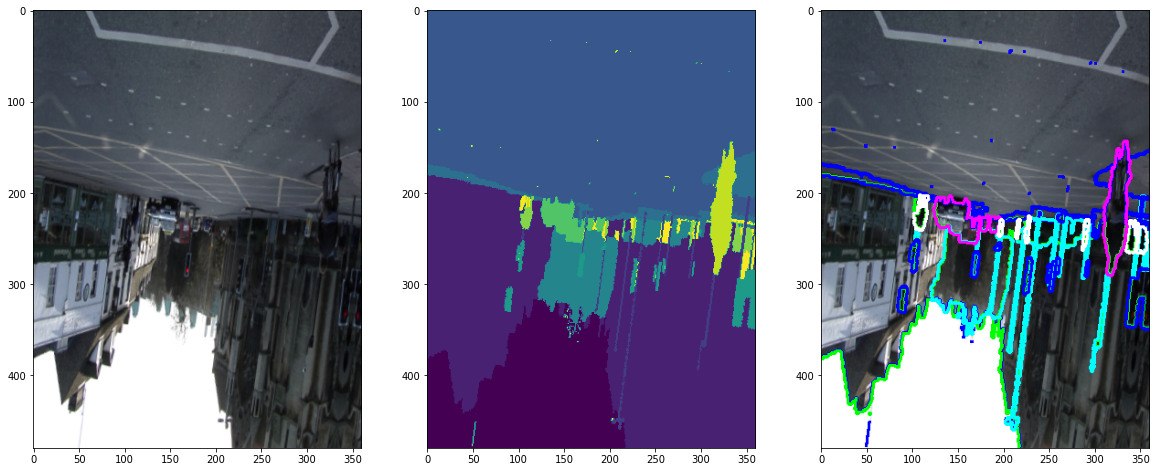

In [ ]:
plt.figure(figsize = (20,20))
img_r = re_normalize(img)
plt.subplot(1,3,1)
plt.imshow(to_pil_image(img_r))
plt.subplot(1,3,2)
plt.imshow(mask)
plt.subplot(1,3,3)
show_img(img_r, mask)

In [ ]:
train_data = DataLoader(Train_data, batch_size=4, shuffle=True)
validation_data = DataLoader(Val_data, batch_size=8, shuffle=False)

**Double Convolution**

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv= nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)

**UNET Architecture Implementation**

In [ ]:
class UNET(nn.Module):
  def __init__(
          self, in_channels=3, out_channels=11, features =[64,128,256,512],):
    super(UNET, self).__init__()
    self.ups= nn.ModuleList()
    self.downs=nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


    # Down part 
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels =feature

    # Upper part 
    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride =2,
          )
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck= DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []
    
    for down in self.downs:
        x = down (x)
        skip_connections.append(x)
        x = self.pool(x)
    x = self.bottleneck(x)
    skip_connections = skip_connections [::-1]

    for id in range(0, len(self.ups), 2):
        x = self.ups[id](x)
        skip_connection = skip_connections[id//2]

        if x.shape != skip_connection.shape:
            x = TF.resize(x, size = skip_connection.shape[2:])
        concat_skip = torch.cat((skip_connection, x), dim=1)
        x = self.ups[id+1](concat_skip)

    return self.final_conv(x)

In [ ]:
model = UNET(in_channels=3, out_channels=12)

**Summary of model**

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
        DoubleConv-7         [-1, 64, 224, 224]               0
         MaxPool2d-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,728
      BatchNorm2d-10        [-1, 128, 112, 112]             256
             ReLU-11        [-1, 128, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112]         147,456
      BatchNorm2d-13        [-1, 128, 112, 112]             256
             ReLU-14        [-1, 128, 1

**Loss Function and Optimizer**

In [ ]:
loss = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(),lr = 3E-3)

**Dice Loss**

In [ ]:
def dice_loss(input, target):
  smooth =1
  input = torch.argmax(input, dim=1)
  iflat = input.view(-1)
  tflat = target.view(-1)
  intersection = (iflat * tflat).sum()

  return ((2.0 * intersection + smooth)/
          (iflat.sum() + tflat.sum() + smooth)).item()

**Intersection over union IOU**

In [ ]:
def IOU(outputs, labels):
  Smooth = 1e-4
  outputs = torch.argmax(outputs, dim=1)
  
  intersection = (outputs & labels).float().sum((1,2))
  union = (outputs | labels).float().sum((1,2))
  IOU = (intersection + Smooth)/ (union + Smooth)
  mean_IOU = torch.sum(IOU)/4
  return mean_IOU.item()


In [ ]:
def metrics_batch(pred, target):
  pred = torch.argmax(pred, dim=1)
  metric = dice_loss(pred, target)
  return metric

In [ ]:
def Loss_batch(loss_func, output, target, opt=None):
 loss = loss_func(output, target)
 with torch.no_grad():
    Metric=dice_loss(output, target)
    IOU_score = IOU(output, target)
  
 if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()
 return loss.item(), Metric, IOU_score

In [ ]:
optim.lr_scheduler= ReduceLROnPlateau(optimizer, mode ='min', factor=0.5,patience=20, verbose=1)

In [ ]:
def get_lr(optimizer):
  for param in optimizer.param_groups:
    return param['lr']
current_lr = get_lr(optimizer)
print('current learning rate = {}'.format(current_lr))

current learning rate = 1e-05


In [ ]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
 running_loss=0.0
 running_metric=0.0
 running_iou=0.0
 len_data=len(dataset_dl.dataset)
 for xb, yb in dataset_dl:
   output=model(xb)
   loss_b, Metric,IOU_score = Loss_batch(loss_func, output, yb, opt)
   running_loss += loss_b

   if Metric is not None:
     running_metric+=Metric
     if IOU_score is not None:
      running_iou+=Metric
   if sanity_check is True:
     break
 loss=running_loss/float(len_data)
 metric=running_metric/float(len_data)
 iou=running_iou/float(len_data)
 return loss, metric,iou

In [ ]:
def train_val(model, params):
  num_epochs= params['num_epochs']
  loss_func = params['loss_func']
  optimizer = params['optimizer']
  train_data = params['train_data']
  validation_data = params['validation_data']
  sanity_check = params['sanity_check']
  lr_scheduler = params['lr_scheduler']
  path2weights = params['path2weights']

  loss_history = {
      'training':[],
      'validation':[]}
  metric_history = {
      'training':[],
      'validation':[]}
  iou_history = {
      'training':[],
      'validation':[]}

  Best_model_weights = copy.deepcopy(model.state_dict())
  Best_loss = float('inf')

  for epoch in range(num_epochs):
    current_lr=get_lr(optimizer)
    print('Epoch {}/{}, current lr = {}'.format(epoch, num_epochs -1, current_lr))

    model.train()
    train_loss, train_metric, train_iou = loss_epoch(model, loss_func, validation_data, sanity_check, optimizer)

    loss_history['training'].append(train_loss)
    metric_history['training'].append(train_metric)
    iou_history['training'].append(train_iou)

    model.eval()
    with torch.no_grad():
      val_loss, val_metric, val_iou = loss_epoch(model, loss_func,validation_data, sanity_check)

    loss_history['validation'].append(val_loss)
    metric_history['validation'].append(val_metric)
    iou_history['validation'].append(val_iou)

    if val_loss < Best_loss:
      Best_loss = val_loss
      Best_model_weights = copy.deepcopy(model.state_dict())

      torch.save(model.state_dict(), path2weights)
      print('Copied the best model weights')
    
    lr_scheduler.step(val_loss)
    if current_lr != get_lr(optimizer):
      print('Loading best model weights')
      model.load_state_dict(Best_model_weights)

    print('Training loss: %.6f' %(train_loss))
    print('Validatoion loss: %.6f' %(val_loss))
    print('-'*10)
    print(f'Training dice score is {train_metric}')
    print(f'Validation dice score is {val_metric}')
    print(f'Training IOU score is {train_iou}')
    print(f'Validation IOU score is {val_iou}')

  model.load_state_dict(Best_model_weights)
  return model, loss_history, metric_history, iou_history

**Training Model**

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=20, verbose=1)
path2models ='./models/'
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train = {
    'num_epochs':30,
    'optimizer' : optimizer,
    'loss_func' : loss,
    'train_data' : train_data,
    'validation_data': validation_data,
    'sanity_check' :True,
    'lr_scheduler' : lr_scheduler,
    'path2weights': path2models+'sanity_weights.pt',

}
model, loss_hist, metric_his, iou_his = train_val = train_val(model, params_train)

Epoch 0/29, current lr = 1e-05
Copied the best model weights
Training loss: 34426.138614
Validatoion loss: 33469.222772
----------
Training dice score is 0.0362465782920913
Validation dice score is 0.015074368750694955
Training IOU score is 0.0362465782920913
Validation IOU score is 0.015074368750694955
Epoch 1/29, current lr = 1e-05
Training loss: 34127.754950
Validatoion loss: 33480.381188
----------
Training dice score is 0.036583414172181986
Validation dice score is 0.015074368750694955
Training IOU score is 0.036583414172181986
Validation IOU score is 0.015074368750694955
Epoch 2/29, current lr = 1e-05
Training loss: 33840.477723
Validatoion loss: 33492.329208
----------
Training dice score is 0.03682148102486488
Validation dice score is 0.015074368750694955
Training IOU score is 0.03682148102486488
Validation IOU score is 0.015074368750694955
Epoch 3/29, current lr = 1e-05
Training loss: 33564.225248
Validatoion loss: 33504.559406
----------
Training dice score is 0.0369668620647

**Performance measures plotting**

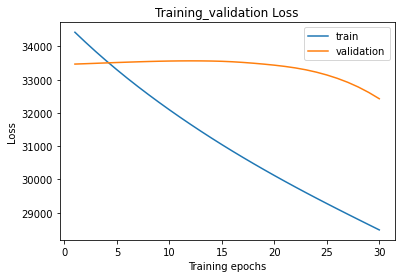

In [ ]:
num_epochs = params_train['num_epochs']
plt.title('Training_validation Loss')
plt.plot(range(1,num_epochs+1), loss_hist['training'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['validation'], label ='validation')
plt.ylabel('Loss')
plt.xlabel('Training epochs')
plt.legend()
plt.show()

**Dice Coefficient Plotting**

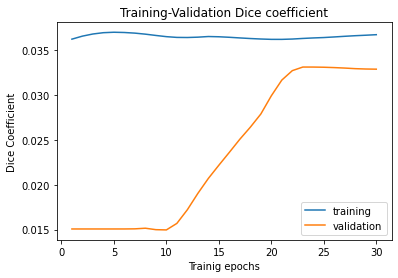

In [ ]:
plt.title('Training-Validation Dice coefficient')
plt.plot(range(1, num_epochs+1), metric_his['training'], label='training')
plt.plot(range(1, num_epochs+1), metric_his['validation'], label = 'validation')
plt.ylabel('Dice Coefficient')
plt.xlabel('Trainig epochs')
plt.legend()
plt.show()


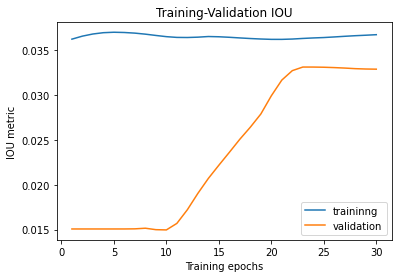

In [ ]:
plt.title('Training-Validation IOU')
plt.plot(range(1,num_epochs+1), iou_his['training'], label='traininng')
plt.plot(range(1, num_epochs+1), iou_his['validation'], label ='validation')
plt.ylabel('IOU metric')
plt.xlabel('Training epochs')
plt.legend()
plt.show()

**Qualitative Results**

In [ ]:
image_1, mask_1 = Val_data[77]
image_2, mask_2 = Val_data[54]
image_3, mask_3 = Val_data[11]
image_4, mask_4 = Val_data[96]

In [ ]:
def get_pred(image):
  image = torch.unsqueeze(image,0)
  prediction = model(image)
  prediction = torch.nn.functional.softmax(prediction, dim=1)
  prediction = torch.squeeze(prediction)
  prediction = torch.argmax(prediction, dim=0)
  return prediction

**plotting iamge 1**

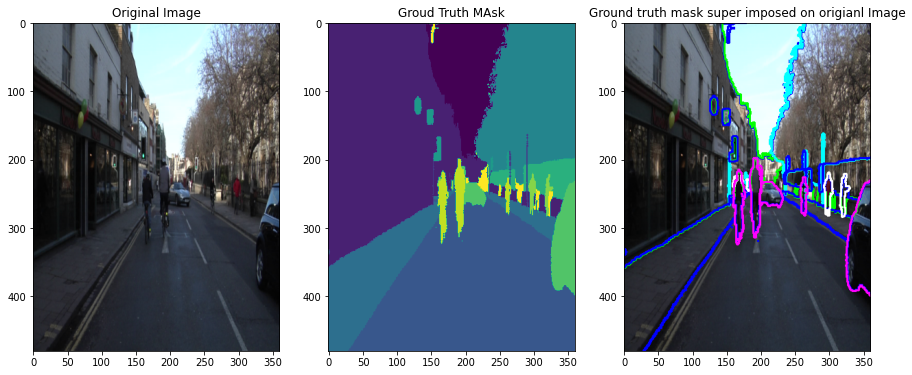

In [ ]:
pred_1 =get_pred(image_1)
plt.figure(figsize=(15,15))
img_r = re_normalize(image_1)
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Groud Truth MAsk')
plt.imshow(mask_1)
plt.subplot(1, 3, 3)
plt.title('Ground truth mask super imposed on origianl Image')
show_img(img_r, mask_1)

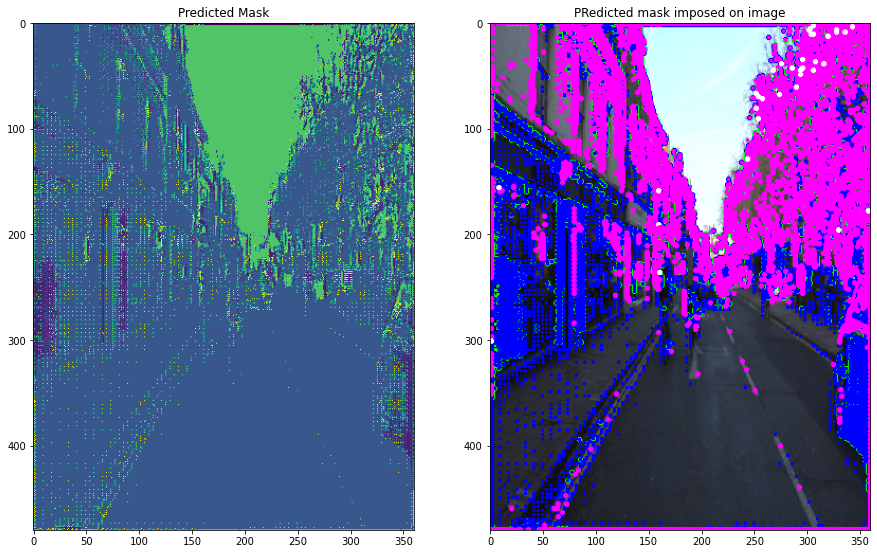

In [ ]:
plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_1)
plt.subplot(1, 2, 2)
plt.title('PRedicted mask imposed on image')
show_img(img_r, pred_1)

Image 2 plotting

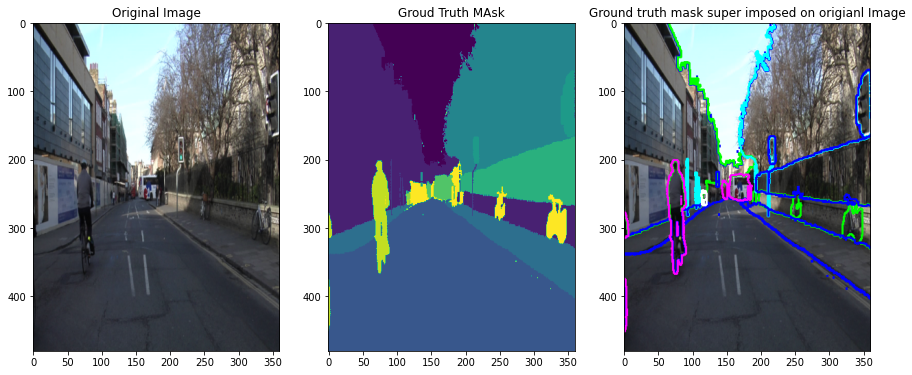

In [ ]:
pred_2 =get_pred(image_2)
plt.figure(figsize=(15,15))
img_r = re_normalize(image_2)
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Groud Truth MAsk')
plt.imshow(mask_2)
plt.subplot(1, 3, 3)
plt.title('Ground truth mask super imposed on origianl Image')
show_img(img_r, mask_2)

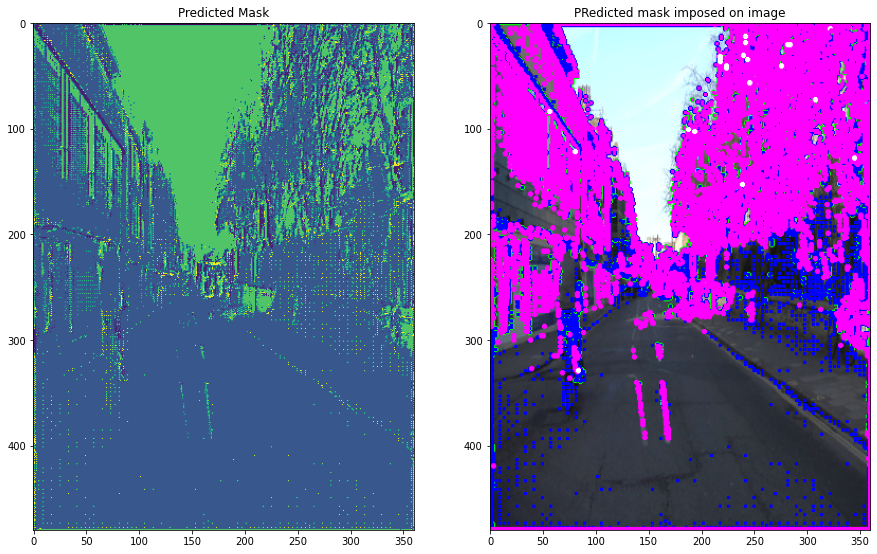

In [ ]:
plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_2)
plt.subplot(1, 2, 2)
plt.title('Predicted mask imposed on image')
show_img(img_r, pred_2)

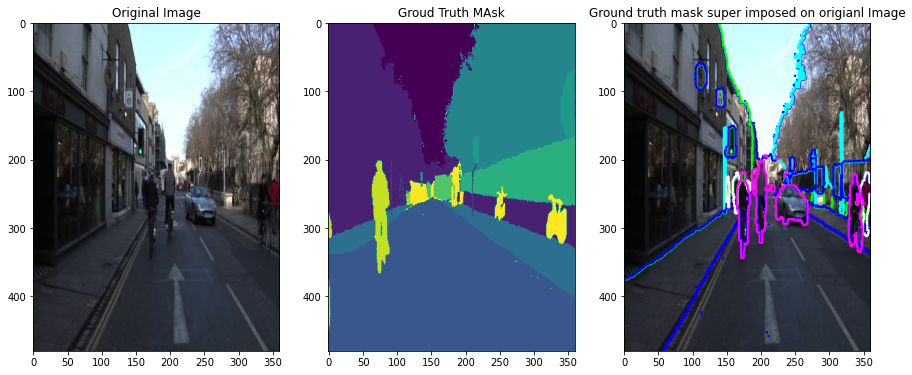

In [ ]:
pred_3 =get_pred(image_3)
plt.figure(figsize=(15,15))
img_r = re_normalize(image_3)
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Groud Truth MAsk')
plt.imshow(mask_2)
plt.subplot(1, 3, 3)
plt.title('Ground truth mask super imposed on origianl Image')
show_img(img_r, mask_3)

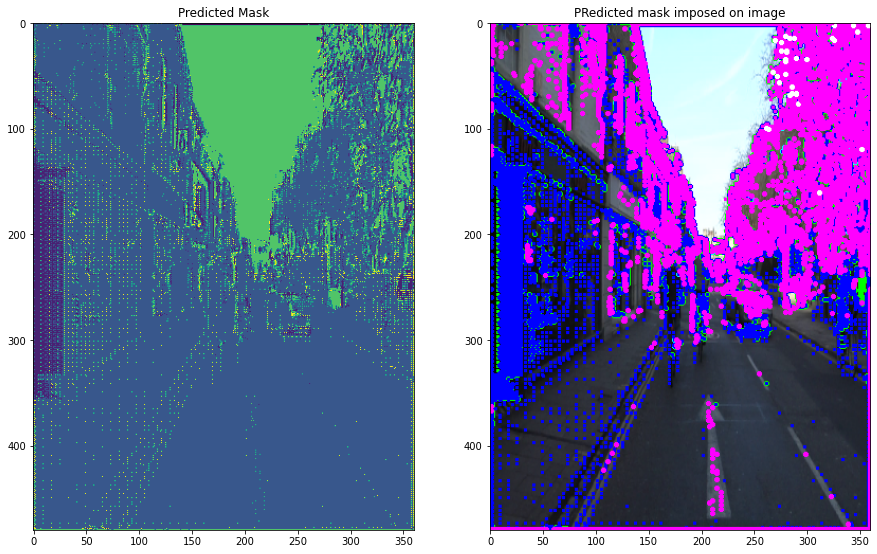

In [ ]:
plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_3)
plt.subplot(1, 2, 2)
plt.title('PRedicted mask imposed on image')
show_img(img_r, pred_3)

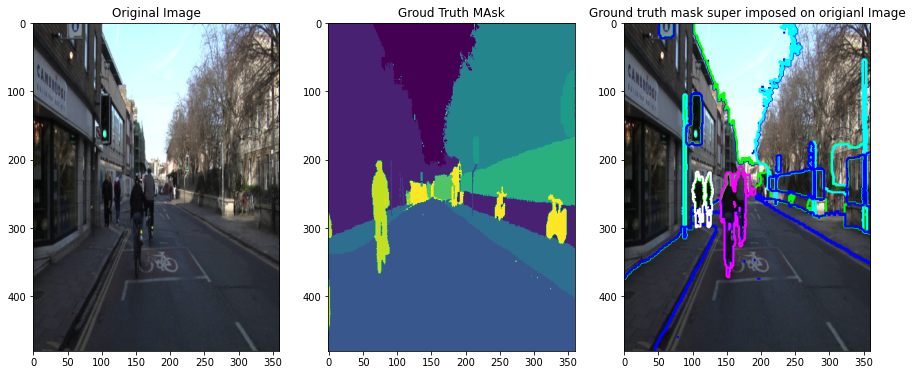

In [ ]:
pred_4 =get_pred(image_4)
plt.figure(figsize=(15,15))
img_r = re_normalize(image_4)
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Groud Truth MAsk')
plt.imshow(mask_2)
plt.subplot(1, 3, 3)
plt.title('Ground truth mask super imposed on origianl Image')
show_img(img_r, mask_4)

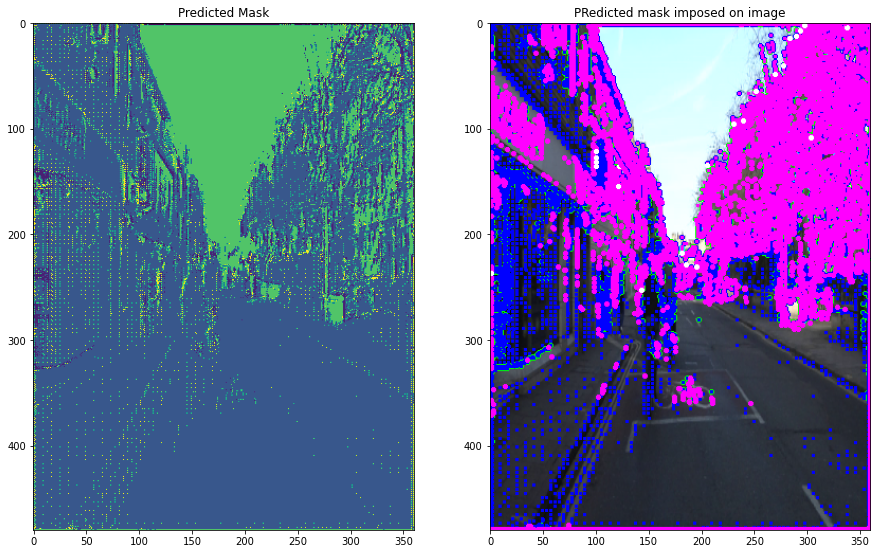

In [ ]:
plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_4)
plt.subplot(1, 2, 2)
plt.title('PRedicted mask imposed on image')
show_img(img_r, pred_4)